In [1]:
import numpy as np
import pandas as pd
import psycopg2

In [2]:
import json

with open('config.json') as f:
    conf = json.load(f)
    host = conf['host']
    database = conf['database']
    user = conf['user']
    passw = conf['passw']

In [3]:
conn_str = "host={} dbname={} user={} password={}".format(host, database, user, passw)
conn = psycopg2.connect(conn_str)

In [4]:
query = '''
SELECT      DISTINCT inc.incident_id,
            date_part('year',inc.incident_date),
            vic.age_num,
            vic.sex_code AS VICTIM_SEX,
            oft.offense_category_name AS OFFENSE_CATEGORY,
            ori.countyname AS COUNTY
            
FROM        nibrs_victim as vic
JOIN        nibrs_offense as off
ON          off.incident_id = vic.incident_id
JOIN        nibrs_offense_type as oft
ON          oft.offense_type_id = off.offense_type_id
JOIN        nibrs_incident as inc
ON          inc.incident_id = vic.incident_id
JOIN        cde_agencies as ags
ON          ags.agency_id = inc.agency_id
JOIN        ori_to_fips as ori
ON          ori.ori9 = ags.ori

WHERE       vic.victim_type_id = 4
AND         inc.incident_date BETWEEN '2016-01-01' AND '2016-12-31';
'''

In [5]:
df = pd.read_sql(query, con=conn)
df.head(3).T

,0,1,2
incident_id,87264241,87264244,87264248
date_part,2016,2016,2016
age_num,59,50,26
victim_sex,F,M,F
offense_category,Larceny/Theft Offenses,Fraud Offenses,Larceny/Theft Offenses
county,BURNET,BURNET,BURNET


In [6]:
crime_df = df.groupby(['county']).incident_id.agg('count')
crime_df = crime_df.to_frame().reset_index()
crime_df = crime_df.rename({'incident_id': 'crime_cnt'}, axis='columns')
crime_df

,county,crime_cnt
0,BELL,3348
1,BEXAR,392
2,BRAZORIA,2994
3,BREWSTER,70
4,BURNET,342
5,CALHOUN,756
6,CAMERON,2
7,COLLIN,16800
8,CORYELL,111
9,DALLAS,4395


In [7]:
df =df.join(crime_df.set_index('county'), on='county')

In [8]:
df.head()

,incident_id,date_part,age_num,victim_sex,offense_category,county,crime_cnt
0,87264241,2016.0,59.0,F,Larceny/Theft Offenses,BURNET,342
1,87264244,2016.0,50.0,M,Fraud Offenses,BURNET,342
2,87264248,2016.0,26.0,F,Larceny/Theft Offenses,BURNET,342
3,87264256,2016.0,25.0,F,Assault Offenses,CAMERON,2
4,87264264,2016.0,26.0,M,Larceny/Theft Offenses,CAMERON,2


In [9]:
age_df = df[['victim_sex','age_num']]

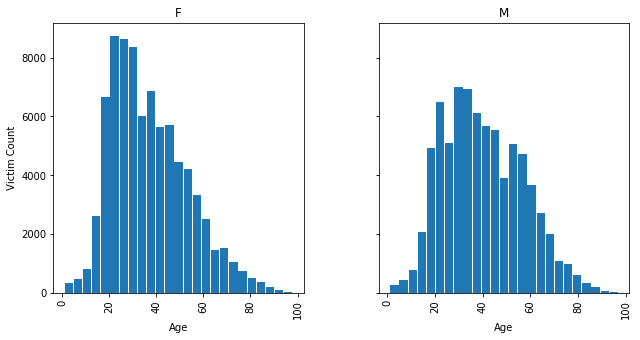

In [14]:
age_df.columns = ['victim_sex','age_num']
age_df = age_df[age_df["victim_sex"] != 'U']

axarr = age_df.hist(column='age_num', by ='victim_sex', bins=25, rwidth=0.9, sharex=False, sharey=True, layout = (1, 2), figsize=(10,5))

for ax in axarr.flatten():
    ax.set_xlabel("Age")
    ax.set_ylabel("Victim Count")

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

age_df = age_df[age_df["victim_sex"] != 'U']
age_df.dropna(subset=['age_num'], inplace=True)
f = pd.Series(age_df.age_num[age_df["victim_sex"] == 'F'])
m = pd.Series(age_df.age_num[age_df["victim_sex"] == 'M'])

/home/kendal/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


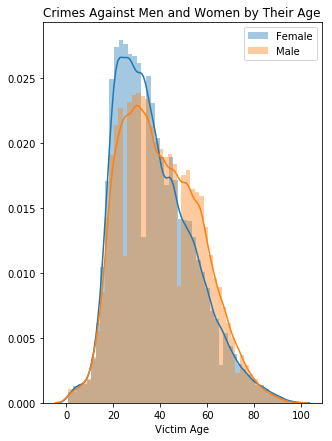

In [12]:
fig, ax = plt.subplots(figsize=(5, 7))
ax = sns.distplot(f, label='Female')
ax = sns.distplot(m, axlabel='Victim Age', label='Male')
ax.legend()
plt.title('Crimes Against Men and Women by Their Age')
plt.show()

In [43]:
off_df = df[['victim_sex','offense_category']]
off_df.head()

,victim_sex,offense_category
0,F,Larceny/Theft Offenses
1,M,Fraud Offenses
2,F,Larceny/Theft Offenses
3,F,Assault Offenses
4,M,Larceny/Theft Offenses


In [44]:
off_df.offense_category.unique()

array(['Larceny/Theft Offenses', 'Fraud Offenses', 'Assault Offenses',
       'Destruction/Damage/Vandalism of Property',
       'Burglary/Breaking & Entering', 'Counterfeiting/Forgery',
       'Motor Vehicle Theft', 'Robbery', 'Drug/Narcotic Offenses',
       'Sex Offenses', 'Extortion/Blackmail', 'Weapon Law Violations',
       'Kidnapping/Abduction', 'Homicide Offenses',
       'Pornography/Obscene Material', 'Arson',
       'Stolen Property Offenses', 'Embezzlement', 'Human Trafficking',
       'Bribery', 'Prostitution Offenses'], dtype=object)

In [50]:
off_df = off_df.replace({'offense_category' : { 'Arson' : 'Other','Stolen Property Offenses' : 'Other', 
                                      'Embezzlement' : 'Other', 'Pornography/Obscene Material' : 'Other',
                                      'Prostitution Offenses' : 'Other', 'Bribery' : 'Other',
                                      'Human Trafficking' : 'Other' }})

In [52]:
off_df.offense_category.value_counts()

Larceny/Theft Offenses                      50944
Assault Offenses                            43404
Destruction/Damage/Vandalism of Property    19442
Burglary/Breaking & Entering                16122
Fraud Offenses                              12070
Motor Vehicle Theft                          6941
Robbery                                      3216
Sex Offenses                                 2901
Counterfeiting/Forgery                       1985
Drug/Narcotic Offenses                       1624
Kidnapping/Abduction                          821
Other                                         651
Weapon Law Violations                         479
Homicide Offenses                             174
Extortion/Blackmail                            42
Name: offense_category, dtype: int64

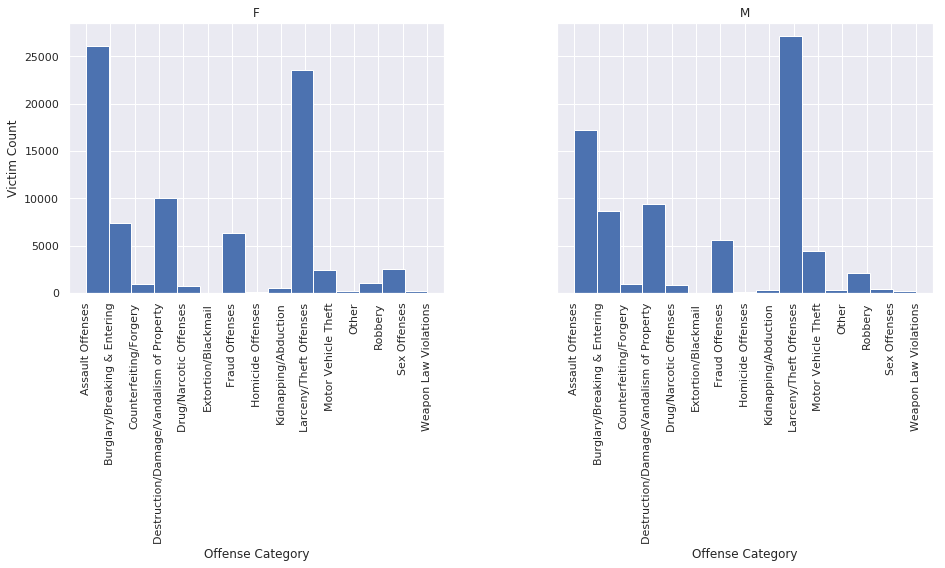

In [53]:
off_df.columns = ['victim_sex','offense_category']
off_df = off_df[off_df["victim_sex"] != 'U']

axarr = off_df.hist(column='offense_category', by = 'victim_sex', bins=15, sharex=True, sharey=True, layout = (1, 2), figsize=(15,5))

for ax in axarr.flatten():
    ax.set_xlabel("Offense Category")
    ax.set_ylabel("Victim Count")

In [54]:
f_df = off_df[off_df["victim_sex"] == 'F']
m_df = off_df[off_df["victim_sex"] == 'M']

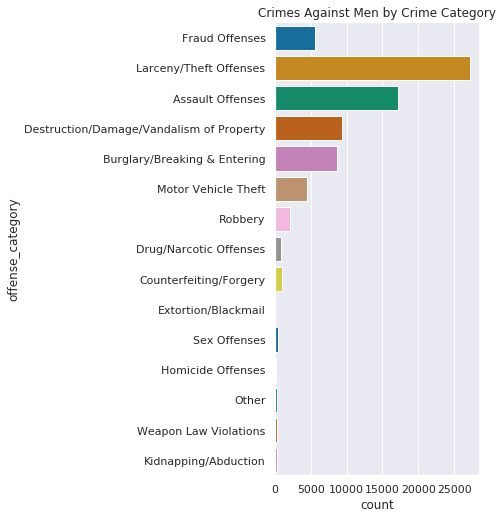

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
sns.set(rc={'figure.figsize':(5,5)})

ax = sns.catplot(y="offense_category", kind="count", palette="colorblind", height=7, data=m_df);

plt.title('Crimes Against Men by Crime Category')
plt.show()

In [59]:
m_df.offense_category.value_counts()

Larceny/Theft Offenses                      27161
Assault Offenses                            17222
Destruction/Damage/Vandalism of Property     9342
Burglary/Breaking & Entering                 8649
Fraud Offenses                               5610
Motor Vehicle Theft                          4477
Robbery                                      2118
Counterfeiting/Forgery                        982
Drug/Narcotic Offenses                        814
Sex Offenses                                  386
Other                                         329
Kidnapping/Abduction                          308
Weapon Law Violations                         240
Homicide Offenses                             119
Extortion/Blackmail                            23
Name: offense_category, dtype: int64

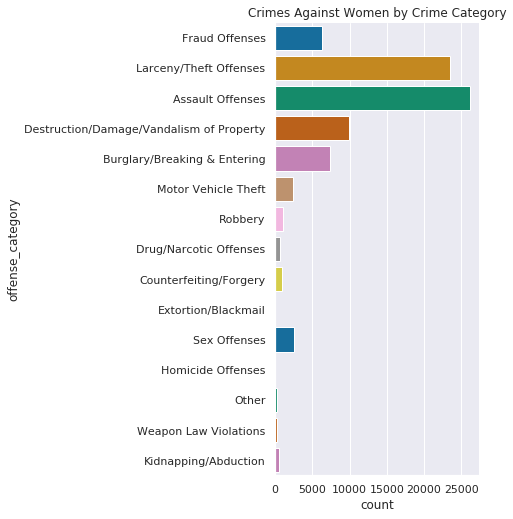

In [58]:
ax = sns.catplot(y="offense_category", kind="count", palette="colorblind", height=7, data=f_df,
                order = ['Fraud Offenses', 'Larceny/Theft Offenses', 'Assault Offenses', 
                         'Destruction/Damage/Vandalism of Property', 'Burglary/Breaking & Entering',
                        'Motor Vehicle Theft', 'Robbery','Drug/Narcotic Offenses', 'Counterfeiting/Forgery',
                        'Extortion/Blackmail', 'Sex Offenses', 'Homicide Offenses', 'Other',
                        'Weapon Law Violations', 'Kidnapping/Abduction']);

plt.title('Crimes Against Women by Crime Category')
plt.show()

In [60]:
f_df.offense_category.value_counts()

Assault Offenses                            26105
Larceny/Theft Offenses                      23535
Destruction/Damage/Vandalism of Property     9988
Burglary/Breaking & Entering                 7422
Fraud Offenses                               6344
Sex Offenses                                 2512
Motor Vehicle Theft                          2428
Robbery                                      1090
Counterfeiting/Forgery                        947
Drug/Narcotic Offenses                        718
Kidnapping/Abduction                          512
Other                                         248
Weapon Law Violations                         196
Homicide Offenses                              52
Extortion/Blackmail                            19
Name: offense_category, dtype: int64

### Calculate Percent Increase of Assault Offenses Against Women vs Men

In [61]:
(26105-17222)/17222

0.5157937521774475

### Calculate Percent Increase of Larceny Offenses Against Women vs Men

In [64]:
(27161-23535)/23535

0.1540684087529212

In [ ]:
[27161,17222,9342,8649,5610,4477,2118,982,814,386,329,308,240,119,23]
[23535,26105,9988,7422,6344,2428,1090,947,718,2512,248,512,196,52,19] 

In [68]:
from scipy.stats import chi2_contingency
obs = np.array([[26105, 23535, 2512], [17222, 27161, 386]])
chi2 = chi2_contingency(obs)
chi2

(3095.774361102716,
 0.0,
 2,
 array([[23313.72668462, 27278.89510013,  1559.37821525],
        [20013.27331538, 23417.10489987,  1338.62178475]]))

In [69]:
from scipy.stats import chi2_contingency
obs = np.array([[27161,17222,9342,8649,5610,4477,2118,982,814,386,329,308,240,119,23], 
                [23535,26105,9988,7422,6344,2428,1090,947,718,2512,248,512,196,52,19] ])
chi2 = chi2_contingency(obs)
chi2

(4723.733794475081,
 0.0,
 14,
 array([[2.46606224e+04, 2.10760373e+04, 9.40290814e+03, 7.81759631e+03,
         5.81491795e+03, 3.35887639e+03, 1.56050333e+03, 9.38345049e+02,
         7.45227898e+02, 1.40970656e+03, 2.80676565e+02, 3.98881773e+02,
         2.12088357e+02, 8.31814429e+01, 2.04305298e+01],
        [2.60353776e+04, 2.22509627e+04, 9.92709186e+03, 8.25340369e+03,
         6.13908205e+03, 3.54612361e+03, 1.64749667e+03, 9.90654951e+02,
         7.86772102e+02, 1.48829344e+03, 2.96323435e+02, 4.21118227e+02,
         2.23911643e+02, 8.78185571e+01, 2.15694702e+01]]))

In [ ]:
df['victim_sex'].value_counts()

In [ ]:
df['offense_category'].unique()

In [ ]:
df.groupby(['victim_sex','offense_category']).incident_id.agg('count')

In [ ]:
hospitals = pd.read_csv('hosp_query.csv')
hospitals.head(3).T

In [ ]:
hospitals['beds'] = hospitals['beds'].clip_lower(0)

In [ ]:
hosp_cnt = hospitals.groupby('county').hosp_id.agg('count')

In [ ]:
hosp_cnt = hosp_cnt.to_frame().reset_index()

In [ ]:
hosp_cnt

In [ ]:
test_merge = hospitals.merge(hosp_cnt,on='county')

In [ ]:
test_merge.head(3).T

In [ ]:
bed_cnt = hospitals.groupby('county').beds.agg('sum')

In [ ]:
bed_cnt = bed_cnt.to_frame().reset_index()

In [ ]:
bed_cnt

In [ ]:
hosp = test_merge.merge(bed_cnt,on='county')

In [ ]:
hosp.head(3).T

In [ ]:
hosp = hosp.rename({'hosp_id_x': 'id', 'hosp_id_y': 'count', 'beds_x': 'beds', 'beds_y': 'bed_count'}, axis='columns')

In [ ]:
hosp.head(3).T

In [ ]:
hosp_merge = hosp[['county','count','bed_count']]

In [ ]:
#df = df.merge(hosp_merge,on='county')
df = df.join(hosp_merge.set_index('county'), on='county')

In [ ]:
df.head(3).T